In [3]:
import torch.nn as nn
import torch
from torchvision import models
from datasets.linemod.dataset import DepthDataset
import torch
import os
import torch.nn.functional as F
from lib.loss_depth import L2Loss, GradientLoss, NormalLoss, BerHu
from torch import optim
import numpy as np
import time
import matplotlib.pyplot as plt
from lib.utils import setup_logger, im_convert, depth_to_img
from lib.network import DepthV3
from lib.utils import visualize

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore") 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
dataset_root = "./datasets/linemod/Linemod_preprocessed"
log_dir = 'experiments/logs/depth_prediction'
outf = 'trained_models/depth_prediction'

In [17]:
dataset = DepthDataset('train', dataset_root)
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=2, 
                                         shuffle=True, 
                                         num_workers=1)

test_dataset = DepthDataset('test', dataset_root)
testdataloader = torch.utils.data.DataLoader(test_dataset, 
                                             batch_size=1, 
                                             shuffle=True, 
                                             num_workers=1)

Object 6 buffer loaded
Object 8 buffer loaded
Object 9 buffer loaded
Object 12 buffer loaded
Object 13 buffer loaded
Object 14 buffer loaded
Object 15 buffer loaded
Object 6 buffer loaded
Object 8 buffer loaded
Object 9 buffer loaded
Object 12 buffer loaded
Object 13 buffer loaded
Object 14 buffer loaded
Object 15 buffer loaded


In [7]:
model = 'trained_models/depth_prediction/pose_model_8_71.07109753379609.pth'
estimator = DepthV3((480, 640))
estimator.load_state_dict(torch.load(model))
estimator.cuda()
lr = 0.0001
optimizer = optim.Adam(estimator.parameters(), lr=lr)
# optimizer = optim.SGD(estimator.parameters(), lr, momentum=0.9, weight_decay=1e-4)
batch_size = 8
print_every = 32

lossLogL2 = L2Loss()
lossGrad = GradientLoss()
lossNormal = NormalLoss()
berhu = BerHu()


In [8]:
# lr *= 0.1
# optimizer = optim.Adam(estimator.parameters(), lr=lr)

In [9]:
len(dataloader)

637

In [ ]:
start_epoch = 9
nepoch = 20
repeat_epoch = 1
best_test = np.Inf
grad_after = 0
normal_after = 0

if start_epoch == 1:
    for log in os.listdir(log_dir):
        if '.ipyn' not in log:
            os.remove(os.path.join(log_dir, log))
st_time = time.time()


for epoch in range(start_epoch, nepoch):
    mess = 'Train time {0}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)) + ', ' + 'Training started')
    print(mess)
    
    train_count = 0
    loss_avg = 0.0
    loss_l2_avg = 0.0
    loss_normal_avg = 0.0
    loss_grad_avg = 0.0
    train_loss_avg = 0.0
    estimator.train()
    optimizer.zero_grad()
    

    for i, data in enumerate(dataloader, 0):
        img, depth = data
        depth = depth.unsqueeze(1)
#         max_d = torch.max(depth)
#         min_d = torch.min(depth)
#         depth_norm = (depth - min_d) * 255 / (max_d - min_d)

#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
#         ax1.imshow(im_convert(img))
#         ax1.axis("off")
#         ax2.imshow(depth_to_img(depth_norm), cmap='gray')
#         ax2.axis("off")
#         plt.show()
        
        img, depth = img.float().cuda(), depth.float().cuda()
        pred_depth = estimator(img)

        loss_L2 = berhu(pred_depth, depth) 
        loss_grad = lossGrad(pred_depth, depth) * (epoch > grad_after)
        loss_normal = lossNormal(pred_depth, depth) * (epoch > normal_after)
        total_loss = loss_L2 + loss_normal + loss_grad
        
        total_loss.backward()
        

        loss_avg += total_loss.item()
        loss_l2_avg += loss_L2.item()
        loss_normal_avg += loss_normal.item()
        loss_grad_avg += loss_grad.item()
        train_loss_avg += total_loss.item()
        train_count += 1

        if train_count % batch_size == 0:

            optimizer.step()
            optimizer.zero_grad()
            
 
            if train_count % print_every == 0:
                mess = 'Train time {0} Epoch {1} Batch {2} Frame {3}\nAvg_loss: {4:.6f} loss_l2: {5:.6f} loss_grad: {6:.6f} loss_normal: {7:.6f}'.format(
                            time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), 
                            epoch, int(train_count / batch_size), 
                            train_count, 
                            loss_avg / batch_size, 
                            loss_l2_avg / batch_size, 
                            loss_grad_avg / batch_size, 
                            loss_normal_avg / batch_size)
                print(mess)
                
            loss_avg = 0
            loss_avg = 0.0
            loss_l2_avg = 0.0
            loss_normal_avg = 0.0
            loss_grad_avg = 0.0

        if train_count != 0 and train_count % 500 == 0:                    
            torch.save(estimator.state_dict(), '{0}/pose_model_current.pth'.format(outf))

    print('>>>>>>>>----------epoch {0} train finish---------<<<<<<<<'.format(epoch))
    
    test_loss = 0.0
    test_count = 0
    estimator.eval()
    plot = True
    
    for j, data in enumerate(testdataloader, 0):
        img, depth = data
        depth = depth.unsqueeze(0)
        
        img, depth = img.float().cuda(), depth.float().cuda()
        
        pred_depth = estimator(img)
        
        loss_L2 = berhu(pred_depth, depth) 
        loss_grad = lossGrad(pred_depth, depth) * (epoch > grad_after)
        loss_normal = lossNormal(pred_depth, depth) * (epoch > normal_after)
        total_loss = loss_L2 + loss_normal + loss_grad
        
        test_loss += total_loss.item()
        test_count += 1
        
        if plot:
            visualize(img, depth[0].view(480, 640).cpu().detach(), pred_depth[0].view(480, 640).cpu().detach())
            plt.show()
            plot= False
                
    test_loss = test_loss / test_count
    mess = 'Test time {0} Epoch {1} TEST FINISH Avg loss: {2} Train avg loss: {3}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), epoch, test_loss, train_loss_avg/len(dataloader))
    print(mess)
    train_loss_avg = 0.0
    
    torch.save(estimator.state_dict(), '{0}/pose_model_{1}_{2}.pth'.format(outf, epoch, test_loss))
    print(epoch, '>>>>>>>>----------MODEL SAVED---------<<<<<<<<')
           

# Evaluate

In [5]:
eval_dataset = DepthDataset('eval', dataset_root)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, 
                                              batch_size=1,
                                              shuffle=True,
                                              num_workers=1)

eval_iter = iter(eval_dataloader)

Object 2 buffer loaded
Object 4 buffer loaded
Object 5 buffer loaded
Object 10 buffer loaded
Object 11 buffer loaded


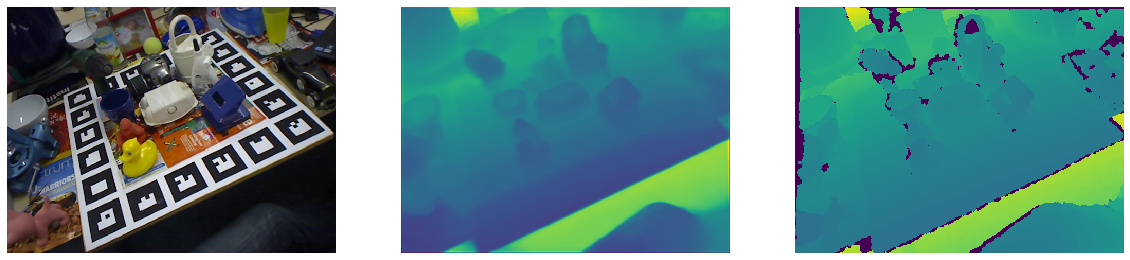

In [6]:
t = next(eval_iter)
img, depth = t
img, depth = img.float().cuda(), depth.float().cuda()

model = 'trained_models/depth_prediction/depthv3_71.07109753379609.pth'
estimator = estimator = DepthV3((480, 640))
estimator.load_state_dict(torch.load(model))
estimator.cuda()
estimator.eval()

pred_depth = estimator(img).cpu().detach().view(480, 640)
depth = depth.cpu().view(480, 640)

visualize(img, depth, pred_depth)